# Observation and Action

<img align="right" src="figs/observation_demo.png" width=260>

MetaDrive provides various kinds of sensory input, as illustrated in the next figure.
For low-level sensors, RGB cameras, depth cameras, semantic camera, instance camera and Lidar can be placed anywhere in the scene with adjustable
parameters such as view field and the laser number.
Meanwhile, the high-level scene information including the road information and nearby vehicles' information like velocity and heading can also be provided as the observation.

Note that MetaDrive aims at providing an efficient platform to benchmark RL research,
therefore we improve the simulation efficiency at the cost of photorealistic rendering effect.

In this page, we describe the optional observation forms in current MetaDrive version and discuss how to implement new forms of observation subject to your own tasks.


## Observations
There are three kinds of observations we usually used for training agents:
- LidarStateObservation
- ImageStateObservation
- TopDownObservation

By default, the observation is `LidarStateObservation`.

### LidarStateObservation
This observation returns a state vector containing necessary information for navigation tasks.
We use this state vector in almost all existing RL experiments such as the Generalization, MARL and Safe RL experiments.
The state vector consist of three parts:
1. **Ego State**: current states such as the steering, heading, velocity and relative distance to boundaries, implemented in the `vehicle_state` function of [StateObservation](https://github.com/metadriverse/metadrive/blob/main/metadrive/obs/state_obs.py). Please find the detailed meaning of each state dimension in the code.
2. **Navigation**: the navigation information that guides the vehicle toward the destination. Concretely, MetaDrive first computes the route from the spawn point to the destination of the ego vehicle. Then a set of checkpoints are scattered across the whole route with certain intervals. The relative distance and direction to the next checkpoint and the next next checkpoint will be given as the navigation information. This part is implemented in the `_get_info_for_checkpoint` function of [Navigation Class](https://github.com/metadriverse/metadrive/blob/9a89962e72c709e60d4a5bc19ce5f27d96027401/metadrive/component/vehicle_navigation_module/base_navigation.py).
3. **Surrounding**: the surrounding information is encoded by a vector containing the Lidar-like cloud points. The data is generated by the [Lidar Class](https://github.com/metadriverse/metadrive/blob/main/metadrive/component/sensors/lidar.py). We typically use 240 lasers (single-agent) and 70 lasers (multi-agent) to scan the neighboring area with radius 50 meters.

The above information is normalized to [0,1] and concatenated into a state vector by the [LidarStateObservation Class](https://github.com/metadriverse/metadrive/blob/9a89962e72c709e60d4a5bc19ce5f27d96027401/metadrive/obs/state_obs.py) and fed to the RL agents. Now let's dive into the observation class and get you familiar with the state information collection.

#### 1. Ego State


#### 2. Navigation
#### 3. Lidar

### ImageStateObservation


<img align="center" src="figs/rgb_obs.png" width=350>
<img align="center" src="figs/depth_obs.jpg" width=350>

MetaDrive supports visuomotor tasks by rendering 3D scenes during the training.
The above figure shows the images captured by RGB camera (left) and depth camera (right).
By using `ImageStateObservation`, the image data will be returned with **Ego State** and **Navigation** for making the driving decision. In this section, we discuss how to utilize this observation. 

Before using such function in your project, please make sure the offscreen rendering is working in your machine. The setup tutorial is at <a href="install.html#install-metadrive-with-headless-rendering">Install MetaDrive with headless rendering</a>. There are two official examples using RGB camera as observation:
```bash
python -m metadrive.examples.drive_in_single_agent_env --observation rgb_camera

# options for `--camera`: rgb main semantic depth
python -m metadrive.examples.verify_image_observation --camera rgb 
```

Concretely, to setup the vision-based observation, there are three steps:

* Step 1. Set the `config["image_observation"] = True` to tell MetaDrive maintaining a image buffer in memory even no popup window exists.
* Step 2. Notify the simulator what kind of sensor you are going to create in the config. A unique name should be assigned for this sensor. The image size (width and height) will be determined by the camera parameters. 
* Step 3. Set the `config["vehicle_config"]["image_source"]` to the sensor name. Here it should be `rgb_camera`. 

An example creating RGB camera is as follows. It creates an `RGBCamera` with resolution=(width, height)=(256, 128). We then tell the engine to launch the image observation and retrieve the image from sensor whose id name `rgb_camera`.

In [ ]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.component.sensors.rgb_camera import RGBCamera
from metadrive.component.sensors.semantic_camera import SemanticCamera
from metadrive.component.sensors.depth_camera import DepthCamera
import cv2
from metadrive.policy.idm_policy import IDMPolicy
import os
sensor_size = (84, 60) if os.getenv('TEST_DOC') else (256, 128)

cfg=dict(image_observation=True, 
         vehicle_config=dict(image_source="rgb_camera"),
         sensors={"rgb_camera": (RGBCamera, *sensor_size)},
         agent_policy=IDMPolicy # drive with IDM policy
        )

env=MetaDriveEnv(cfg)
try:
    env.reset()
    for _ in range(5 if os.getenv('TEST_DOC') else 10000):
         # simulation
        o, r, d, _, _ = env.step([0,1])
        
        # rendering, the last one is the current frame
        ret = o["image"][..., -1] 
        # disable visualization when testing
        if not os.getenv('TEST_DOC'):
            cv2.imshow("window", ret)
            cv2.waitKey(1)
        if d:
            cv2.destroyAllWindows()
            break
finally:
    env.close()

Rendering images and buffering the image observations consume both the GPU and CPU memory of your machine. Please be careful when using this. If you feel the visual data collection is slow, why not try our advanced offscreen render: <a href="install.html#install-metadrive-with-advanced-offscreen-rendering">Install MetaDrive with advanced offscreen rendering</a>. After verifying your installation, set `config["image_on_cuda"] = True` to get **10x** faster rollout efficiency! It will keep the rendered image on the GPU memory all the time for training, so please ensure your GPU has enough memory to store them. 

### TopDownObservation
<img align="center" src="figs/top_down_obs.png" width=600>

MetaDrive also supports Top-down semantic maps. We provide a handy example to illustrate the utilization of Top-down observation in [top_down_metadrive.py]( https://github.com/metadriverse/metadrive/blob/main/metadrive/examples/top_down_metadrive.py).
You can enjoy this demo via
```bash
python -m metadrive.examples.top_down_metadrive
```
The following is a minimal script to use Top-down observation.
The `TopDownMetaDrive` is a wrapper class on `MetaDriveEnv` which overrides observation to pygame top-down renderer.
The native observation of this setting is a numpy array with shape `[84, 84, 5]` and all entries fall into [0, 1].
The above figure shows the semantic meaning of each channel.

In [ ]:
from metadrive import TopDownMetaDrive

env = TopDownMetaDrive()
try:
    o,i = env.reset()
    for s in range(1, 100000):
        o, r, tm, tc, info = env.step([0, 1])
        env.render(mode="top_down")
        if tm or tc:
            break
            env.reset()
finally:
    env.close()

### Customizing Observation
We encourage users to design observations according to specific demand. For all environments, the observation of the agent is determined by the function `env.get_single_observation`, which is defined as follows:

In [4]:
import inspect
from metadrive.envs.metadrive_env import MetaDriveEnv
print(inspect.getsource(MetaDriveEnv.get_single_observation))

    def get_single_observation(self):
        if self.__class__ is BaseEnv:
            o = DummyObservation({})
        else:
            if self.config["agent_observation"]:
                o = self.config["agent_observation"](self.config)
            else:
                img_obs = self.config["image_observation"]
                o = ImageStateObservation(self.config) if img_obs else LidarStateObservation(self.config)
        return o



By default, the observation is `LidarStateObservation`, while `image_observation=True` will change it to `ImageStateObservation`. There are two ways to change the observation class to a customized one. The first way is creating a new environment with the `get_single_observation` overwritten to return your customized observation. `TopDownMetaDrive` is implemented in this way.

In [38]:
import inspect
from metadrive.envs.top_down_env import TopDownMetaDrive, TopDownSingleFrameMetaDriveEnv
print(inspect.getsource(TopDownSingleFrameMetaDriveEnv))
print(inspect.getsource(TopDownMetaDrive))

class TopDownSingleFrameMetaDriveEnv(MetaDriveEnv):
    @classmethod
    def default_config(cls) -> Config:
        config = MetaDriveEnv.default_config()
        # config["vehicle_config"]["lidar"].update({"num_lasers": 0, "distance": 0})  # Remove lidar
        config.update(
            {
                "frame_skip": 5,
                "frame_stack": 3,
                "post_stack": 5,
                "rgb_clip": True,
                "resolution_size": 84,
                "distance": 30
            }
        )
        return config

    def get_single_observation(self, _=None):
        return TopDownObservation(
            self.config["vehicle_config"],
            self.config["rgb_clip"],
            onscreen=self.config["use_render"],
            max_distance=self.config["distance"]
        )

class TopDownMetaDrive(TopDownSingleFrameMetaDriveEnv):
    def get_single_observation(self, _=None):
        return TopDownMultiChannel(
            self.config["vehicle_config"],
      

The second way is specifying the observation class in the field `agent_observation` of the config when creating the environment. The new observation class has to inherit from `ObservationBase` and implement the property `observation_space` (with `@property decorator`) and the function `observe()`. In the following example, we make a customized observation class which collects both vehicle states and images from three types of cameras. 

In [ ]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.component.sensors.rgb_camera import RGBCamera
from metadrive.component.sensors.semantic_camera import SemanticCamera
from metadrive.component.sensors.depth_camera import DepthCamera
import cv2
import gymnasium as gym
import numpy as np
from metadrive.policy.idm_policy import IDMPolicy
from metadrive.obs.observation_base import ObservationBase
from metadrive.obs.image_obs import ImageObservation
from metadrive.obs.state_obs import StateObservation
import os
sensor_size = (84, 60) if os.getenv('TEST_DOC') else (256, 128)

class MyObservation(ObservationBase):
    def __init__(self, config):
        super(MyObservation, self).__init__(config)
        self.rgb = ImageObservation(config, "rgb", config["rgb_clip"])
        self.depth = ImageObservation(config, "depth", config["rgb_clip"])
        self.semantic = ImageObservation(config, "semantic", config["rgb_clip"])
        self.state = StateObservation(config)

    @property
    def observation_space(self):
        os={o: getattr(self, o).observation_space for o in ["rgb", "state", "depth", "semantic"]}
        return gym.spaces.Dict(os)

    def observe(self, vehicle):
        os={o: getattr(self, o).observe(vehicle) for o in ["rgb", "state", "depth", "semantic"]}
        return os

After this, we notify the engine to use this observation with the field `agent_observation`. Note we don't need to specify the `cfg['vehicle_config']['image_source']`, as it is used in `ImageStateObservation` which is already overwritten with our customized observation class. In addition, you have to request corresponding sensors so the observation class can find these sensors from the engine. Actually, you are allowed to create any number of sensors according to your demand. All available sensors can be found at <a href="sensors.html">Sensors</a>. At last, the config should look like:

In [ ]:
cfg=dict(agent_policy=IDMPolicy, # drive with IDM policy
         agent_observation=MyObservation,
         image_observation=True,
         sensors={"rgb": (RGBCamera, *sensor_size),
                  "depth": (DepthCamera, *sensor_size),
                  "semantic": (SemanticCamera, *sensor_size)},
         log_level=50) # turn off log

Once finishing the setup, the following code will launch the simulation and show you the image observations returned by `env.step()`, which should contain images from three cameras.

Observation shape: 
 Dict('depth': Box(-0.0, 1.0, (128, 256, 1, 3), float32), 'rgb': Box(-0.0, 1.0, (128, 256, 3, 3), float32), 'semantic': Box(-0.0, 1.0, (128, 256, 3, 3), float32), 'state': Box(-0.0, 1.0, (19,), float32))


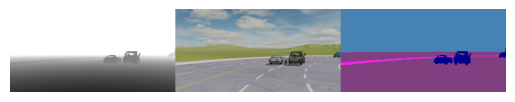

In [5]:
env=MetaDriveEnv(cfg)
try:
    env.reset()
    print("Observation shape: \n", env.observation_space)
    for step in range(5 if os.getenv('TEST_DOC') else 1000):
        o, r, d, _, _ = env.step([0,1]) # simulation
        
        # visualize image observation
        o_1 = o["depth"][..., -1]
        o_1 = np.concatenate([o_1, o_1, o_1], axis=-1) # align channel
        o_2 = o["rgb"][..., -1] 
        o_3 = o["semantic"][..., -1] 
        ret = cv2.hconcat([o_1, o_2, o_3])
        if step<=450:
            to_draw=ret
            
        # disable visualization when testing
        if not os.getenv('TEST_DOC'):
            cv2.imshow("window", ret)
            cv2.waitKey(1)
        if d:
            cv2.destroyAllWindows()
            break
finally:
    env.close()
    
# show observation
from matplotlib import pyplot as plt
plt.imshow(to_draw[...,::-1])
plt.axis('off')
plt.show()

## Action


MetaDrive receives normalized action as input to control each target vehicle: :math:`\mathbf a = [a_1, a_2]^T \in [-1, 1]^2`.

At each environmental time step, MetaDrive converts the normalized action into the steering :math:`u_s` (degree), acceleration :math:`u_a` (hp) and brake signal :math:`u_b` (hp) in the following ways:


.. math::

    u_s & = S_{max} a_1 ~\\
    u_a & = F_{max} \max(0, a_2) ~\\
    u_b & = -B_{max} \min(0, a_2)

wherein :math:`S_{max}` (degree)  is the maximal steering angle, :math:`F_{max}` (hp) is the maximal engine force, and :math:`B_{max}` (hp) is the maximal brake force.
Since the accurate values of these parameters are varying across different types of vehicle, please refer to the [VehicleParameterSpace Class](https://github.com/metadriverse/metadrive/blob/9a89962e72c709e60d4a5bc19ce5f27d96027401/metadrive/component/pg_space.py) for details.

By such design, the action space for each agent is always fixed to `gym.spaces.Box(low=-1.0, high=1.0, shape=(2, ))`. However, we provides a config named `extra_action_dim` (int) which allows user to add more dimensions in the action space.
For example, if we set `config["extra_action_dim"] = 1`, then the action space for each agent will become `Box(-1.0, 1.0, shape=(3, ))`. This allow the user to write environment wrapper that introduce more input action dimensions.